## Import Statements

In [1]:
import numpy as np
import tensorflow as tf
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Concatenate
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.applications.imagenet_utils import preprocess_input
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import scipy.misc
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## ResNet50 Model

In [2]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
        
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
        
    return X

In [3]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # Main  path - first conv
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', padding = 'valid',  kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Main  path - second conv
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Main  path - third conv
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path and RELU activation
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
        
    return X

In [4]:
def ResNet50(input_shape = (100, 100, 3), classes = 13):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters =  [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((2, 2), name = 'avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [5]:
batch_size = 128

datagen = ImageDataGenerator(rescale=1.0/255.0, samplewise_center=True, samplewise_std_normalization=True,
    rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, brightness_range=[0.2,1.0],
    horizontal_flip=True, fill_mode="nearest")

train_it = datagen.flow_from_directory('../input/recaptcha-data/recaptcha_data/train/', target_size=(100, 100), batch_size = batch_size)
val_it = datagen.flow_from_directory('../input/recaptcha-data/recaptcha_data/val', target_size=(100, 100))

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr

optimizer = Adam(learning_rate=0.0001)
lr_metric = get_lr_metric(optimizer)

model = ResNet50(input_shape = (100, 100, 3), classes = 13)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',lr_metric])

Found 16439 images belonging to 13 classes.
Found 4117 images belonging to 13 classes.


In [6]:
history = model.fit(train_it, steps_per_epoch=(16439 // batch_size + 1), epochs=100, validation_data = val_it)

Epoch 1/100
129/129 [==============================] - 233s 2s/step - loss: 2.4353 - accuracy: 0.2620 - lr: 1.0000e-04 - val_loss: 2.2842 - val_accuracy: 0.1861 - val_lr: 1.0000e-04
Epoch 2/100
129/129 [==============================] - 92s 711ms/step - loss: 1.9104 - accuracy: 0.3392 - lr: 1.0000e-04 - val_loss: 2.1377 - val_accuracy: 0.1846 - val_lr: 1.0000e-04
Epoch 3/100
129/129 [==============================] - 91s 708ms/step - loss: 1.7070 - accuracy: 0.3979 - lr: 1.0000e-04 - val_loss: 1.8006 - val_accuracy: 0.3830 - val_lr: 1.0000e-04
Epoch 4/100
129/129 [==============================] - 92s 713ms/step - loss: 1.6162 - accuracy: 0.4357 - lr: 1.0000e-04 - val_loss: 1.5748 - val_accuracy: 0.4452 - val_lr: 1.0000e-04
Epoch 5/100
129/129 [==============================] - 92s 713ms/step - loss: 1.5163 - accuracy: 0.4738 - lr: 1.0000e-04 - val_loss: 1.5799 - val_accuracy: 0.4549 - val_lr: 1.0000e-04
Epoch 6/100
129/129 [==============================] - 92s 717ms/step - loss: 1.42

In [7]:
preds = model.evaluate(val_it)

129/129 [==============================] - 18s 139ms/step - loss: 1.1077 - accuracy: 0.7134 - lr: 1.0000e-04


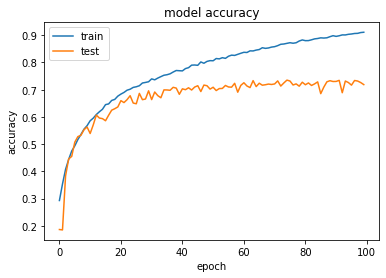

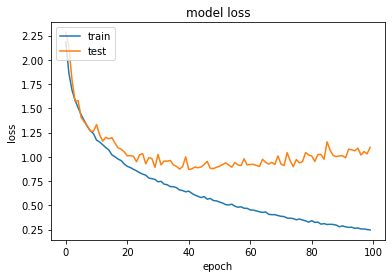

In [9]:
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
model.save('RestNet50')